In [1]:
import pandas as pd
import numpy as np
from math import sqrt
import seaborn as sns
import plotly.express as px
from tqdm.auto import tqdm
from scipy.stats import norm, chi2_contingency, chi2
%matplotlib inline

In [23]:
# Посмотрим на данные 
users_df = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/B4QnY5D5EtKa-A')
groups_df = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/jP_BAw_oxS3law')
purchases_df = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/AmucCdboEaowhA')


print(users_df.head())
print(groups_df.head())
print(purchases_df.head())

   user_id country platform     sex
0     8029  Russia      ios    male
1     1735  Sweden      ios    male
2     7697  Russia  android    male
3     1421  Sweden  android  female
4     1704  Russia      ios    male
   user_id group
0     9149     B
1     9150     B
2     9151     A
3     9152     B
4     9153     B
   user_id  revenue
0     4412   1000.0
1     9000    701.0
2     9001    700.0
3     9002    702.0
4     5790   1002.0


In [25]:

print('user_df data types are:' + '\n', users_df.dtypes)
print('\n' + 'groups_df data types are:' + '\n', groups_df.dtypes)
print('\n' + 'purchases_df data types are:' + '\n', purchases_df.dtypes)

user_df data types are:
 user_id      int64
country     object
platform    object
sex         object
dtype: object

groups_df data types are:
 user_id     int64
group      object
dtype: object

purchases_df data types are:
 user_id      int64
revenue    float64
dtype: object


In [27]:
 # Соберём все данные о пользователях, посещавших приложение во время эксперимента, в один df

df1 = users_df.merge(groups_df, how='left', on='user_id')
df = df1.merge(purchases_df, how='left', on='user_id')


df

,user_id,country,platform,sex,group,revenue
0,8029,Russia,ios,male,B,NaN
1,1735,Sweden,ios,male,B,NaN
2,7697,Russia,android,male,B,NaN
3,1421,Sweden,android,female,B,NaN
4,1704,Russia,ios,male,B,NaN
...,...,...,...,...,...,...
8336,2417,Sweden,ios,female,B,NaN
8337,3755,Russia,ios,male,A,590.0
8338,4594,Sweden,android,female,B,NaN
8339,7430,Sweden,ios,female,B,NaN


In [ ]:
# Посмторим, были ли повторные покупки

df.groupby('user_id').agg({'revenue': 'count'}).sort_values('revenue', ascending=False).head()

In [ ]:
 # повторных покупок не было

In [ ]:
# Разобьём df на контрольную (А) и тестовую (В) группы

control = df.query('group == "A"')
test = df.query('group == "B"')


print(control)
print('\n', test)

In [ ]:
 # Проверим равномерность разбиеня на группы по полу, стране и платформе

In [ ]:
 # По полу:

df_sex = df.groupby(['group', 'sex'], as_index=False).agg({'user_id': 'count'})
sns.barplot(x=df_sex.user_id, y=df_sex.group, hue=df_sex.sex)

In [ ]:
 # По платформе:

df_platform = df.groupby(['group', 'platform'], as_index=False).agg({'user_id': 'count'})
sns.barplot(x=df_platform.user_id, y=df_platform.group, hue=df_platform.platform)

In [ ]:
 # Разбиение по полу и платформе выглядит равномерным

<AxesSubplot:xlabel='user_id', ylabel='group'>

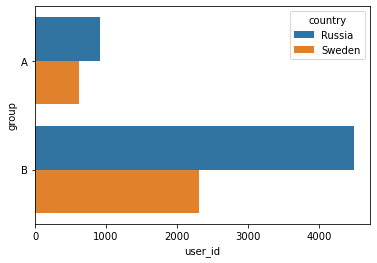

In [28]:
 # По странам

df_country = df.groupby(['group', 'country'], as_index=False).agg({'user_id': 'count'})
sns.barplot(x=df_country.user_id, y=df_country.group, hue=df_country.country)

In [ ]:
# По графику кажется, что разбиение на группы по странам диспропорционально
# Посмотрим внимательнее на соотношение пользователей из разных стран
# Рассчитаем соотношение между пользователями из России и Швеции в общей выборке, контрольной и тестовой группах

all_by_country = df.groupby(['country'], as_index=False).agg({'user_id': 'count'})
all_by_country['ratio'] = round(all_by_country.user_id / all_by_country.user_id.sum(), 2)
print('for all users:' + '\n', all_by_country)


df_country['ratio'] = df_country.groupby('group')\
    .apply(lambda df_country: df_country.user_id / df_country.user_id.sum()).values.round(2)
print('\n' + 'for control and test groups:' + '\n', df_country)

In [ ]:
# Проверим гипотезу о том, что соотношение стран в контрольной группе отличается от соотношения 
# в общем пуле пользователей с помощью критерия хи-квадрат


obs = np.array([[915, 623], [4492, 2311]])
chi2, p, dof, expected = chi2_contingency(obs)
print(p)

In [ ]:
 # p-value<0.05, следовательно в контрольной группе нарушено соотношение между пользователями из России и Швеции
# Сначала проведём A/B тест на всех пользователях, а затем проверим отдельно пользователей из разных стран

In [ ]:
 # В A/B тесте будем отслеживать средний чек и конверсию

In [ ]:
 # Сначала посмотрим, на распределение среднего чека

In [ ]:
sns.distplot(control.revenue)
sns.distplot(test.revenue)

In [ ]:
 px.histogram(df, x="revenue", color="group", marginal="box", opacity=0.75, barmode='group',
             hover_data=df.columns)

In [ ]:
 # Видим, что распределение признака в обеих группах значительно отличается от нормального
# В группе А распределение напоминает гамма-распределение,
# а группе B среднее значительно смещено вправо, по сравнению с группой A
# Выдвинем гипотезу о том, что новая модель оплаты увеличивает средний чек

# Для проверки этой гипотезы воспользуемся бутстрапом, поскольку так мы сможем сымитировать 
# нормальное распределение и оценить доверительный интервал для среднего

In [ ]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа


def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    statistic,  # интересующая нас статистика
    bootstrap_conf_level=0.95,  # уровень значимости
    boot_it=1000  # количество бутстрэп-подвыборок
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len,
            replace=True  # параметр возвращения
        ).values
        samples_2 = data_column_2.sample(
            boot_len,
            replace=True
        ).values
        boot_data.append(statistic(samples_1 - samples_2))
    pd_boot_data = pd.DataFrame(boot_data)
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
    p_1 = norm.cdf(
        x=0,
        loc=np.mean(boot_data),
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0,
        loc=- np.mean(boot_data),
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

# Визуализация
    sns.distplot(pd_boot_data[0])

    return {"ci": ci,
            "p_value": p_value}


control_for_bs = control.loc[control.revenue.notnull()].revenue
test_for_bs = test.loc[test.revenue.notnull()].revenue


get_bootstrap(control_for_bs, test_for_bs, statistic=np.mean)

In [ ]:
# полученное распределение близко к нормальному, 0 не попадает в доверительный интервал,
# следовательно можем отклонить нулевую гипотезу и 
# сделать вывод о статистически значимых различиях средних значений в контрольной и тестовой группах

In [ ]:
# Теперь, поскольку изначальное деление пользователей между группами не было честным,
# рассмотрим отдельно пользователей из России и Швеции, чтобы понять, могло ли неправильное сплитование 
# значимо исказить результат

In [ ]:
# Выделим пользователей из России

control_rus = df.query("country == 'Russia' and group == 'A'")
test_rus = df.query("country == 'Russia' and group == 'B'")


sns.distplot(control_rus.revenue)
sns.distplot(test_rus.revenue)

In [ ]:
 control_for_bs_rus = control_rus.loc[control_rus.revenue.notnull()].revenue
test_for_bs_rus = test_rus.loc[test_rus.revenue.notnull()].revenue


get_bootstrap(control_for_bs_rus, test_for_bs_rus, statistic=np.mean)

In [ ]:
# Выделим пользователей из Швеции

control_swe = df.query("country =='Sweden' and group == 'A'")
test_swe = df.query("country == 'Sweden' and group == 'B'")


sns.distplot(control_swe.revenue)
sns.distplot(test_swe.revenue)

In [ ]:
 control_for_bs_swe = control_swe.loc[control_swe.revenue.notnull()].revenue
test_for_bs_swe = test_swe.loc[test_swe.revenue.notnull()].revenue


get_bootstrap(control_for_bs_swe, test_for_bs_swe, statistic=np.mean)

In [ ]:
# вторая метрика: конверсия в покупку

def calc_cr(df):
    df['cr'] = df.revenue / df.user_id.count()
    df_cr = df.groupby('group', as_index=False).agg({'cr': 'count'})
    df_total = df.groupby('group', as_index=False).agg({'user_id': 'count'})
    cr_a = df_cr.loc[df_cr.group == 'A'].cr / df_total.loc[df_total.group == 'A'].user_id
    cr_b = df_cr.loc[df_cr.group == 'B'].cr / df_total.loc[df_total.group == 'B'].user_id
    return {'cr in group A is': cr_a.round(3), 'cr in group B is': cr_b.round(3)}


calc_cr(df)

In [ ]:
 # Кажется, конверсия немного снизилась в группе В
# Проверим, является ли это изменение статистически значимым
# Для этого рассчитаем 95% доверительный интервал для разности конверсий в группах А и В

def ci_for_cr_diff(cr_a, cr_b, n_a, n_b):
    left_margin = abs(cr_a - cr_b) - 1.96 * sqrt(cr_a * (1 - cr_a) / n_a + cr_b * (1 - cr_b) / n_b)
    right_margin = abs(cr_a - cr_b) + 1.96 * sqrt(cr_a * (1 - cr_a) / n_a + cr_b * (1 - cr_b) / n_b)
    return {'ci': [left_margin, right_margin]}


ci_for_cr_diff(0.051, 0.046, 1538, 6803)

In [ ]:
 # поскольку 0 попадает в доверительный интервал, не можем отвергнуть нулевую гипотезу
# статистически значимых различий между конверсией в контрольной и тестовой группах не удалось обнаружить

In [ ]:
# Посмотрим на конверсию для пользователей из России

calc_cr(df.loc[df.country == 'Russia'])

In [ ]:
ci_for_cr_diff(0.047, 0.044, 915, 4492)

In [ ]:
:  # Посмотрим на конверсию для пользователей из Швеции

calc_cr(df.loc[df.country == 'Sweden'])

In [ ]:
 ci_for_cr_diff(0.056, 0.051, 623, 2311)

In [ ]:
 # В обоих случаях конверсия статистически значимо не меняется

In [ ]:
   # Выводы

# 1. При проведении A/B-теста была нарушена равномерность сплитования и
# в тестовую группу попало относительно больше пользователей из России.
# Во избежание подобных ошибок следовало бы проводить A/A-тест

# 2. В ходе A/B-теста оценивали 2 метрики: средний чек и конверсию в покупку.
# Средний чек вырос в результате внедрения новой системы оплаты, изменения статзначимы
# Конверсия статзначимо не изменилась

# 3. Чтобы оценить возможное искажение результатов эксперимента в результате неравномерного разделения пользователей
# на группы, пользователи из России и Швеции были проанализированы отдельно.
# Результаты повторяют общую тенденцию: средний чек статзначимо вырос, конверсия статзначимо не изменилась

# 4. По итогам A/B-теста можно внедрять новую платёжную систему для всех пользователей,
# но в дальнейшем следует проводить A/A-тесты во избежание ошибок при сплитовании